# Machine Learning - Lab Session 4

This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
- <font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.
- Commit the `.ipynb` file on your github repository and submit URL on E-Ruri

#  Multilayer Perceptron

In this series, we'll be building machine learning models (specifically, neural networks) to perform image classification using `PyTorch` and `Torchvision`. 

In this first notebook, we'll start with one of the most basic neural network architectures, a multilayer perceptron (MLP), also known as a feedforward network. The dataset we'll be using is the famous MNIST dataset, a dataset of 28x28 black and white images consisting of handwritten digits, 0 to 9.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1)

We'll process the dataset, build our model, and then train our model. Afterwards, we'll do a short dive into what the model has actually learned.

## Prerequisite

Let's start by importing all the modules we'll need. The main ones we need to import are:
- torch for general PyTorch functionality
- torch.nn and torch.nn.functional for neural network based functions
- torch.optim for our optimizer which will update the parameters of our neural network
- torch.utils.data for handling the dataset
- torchvision.transforms for data augmentation
- torchvision.datasets for loading the dataset
- sklearn's metrics for visualizing a confusion matrix
- sklearn's decomposition and manifold for visualizing the neural network's representations in two dimensions
- matplotlib for plotting

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

To ensure we get reproducible results we set the random seed for Python, Numpy and PyTorch. **[pts. 5]**

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Data Processing

### Data Loading

The first thing we'll do is load our dataset.

This will automatically download the training set for the MNIST dataset and save it in a folder called `.data`. It will create the folder if it does not exist.

In [5]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

Next, we want to *normalize* our data. This means we want it to have a mean of zero and a standard deviation of one. 

Why do we want to do this? Normalizing our data allows our models to train faster and to also help them avoid local minima, i.e. train more reliably.

We normalize our data by subtracting the mean and dividing by the standard deviation of our dataset. First, we need to calculate the mean and standard deviation. **Note**: it is important that the mean and standard deviation are only calculated over the training set and not the test set. We do not want to use any information at all from the test set and should only look at it when we are calculating our test loss.

To calculate the means and standard deviations we get the actual data (the images) using the `.data.` attribute of our training data, convert them into floating point numbers, and then use the built-in `mean` and `std` functions to calculate the mean and standard deviation, respectively. The image data has values between 0-255, which we want to scale between 0-1, so we divide by 255. **[pts. 5]**

In [6]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [7]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


### Data Transform

Now we've calculated our mean and standard deviation how do we actually use them? We use Torchvision's `transforms`. 

A `transform` states how our data should be augmented and processed. Data augmentation involves manipulating the available training data in a way that artificially creates more training examples. We use `transforms.Compose` to built a list of transformations that will be applied to the image. 

The transforms we use are:
- `RandomRotation` - randomly rotates the image between `(-x, +x)` degrees, where we have set `x = 5`. Note, the `fill=(0,)` is due to a [bug](https://github.com/pytorch/vision/issues/1759) in some versions of torchvision. 
- `RandomCrop` - this first adds `padding` around our image, 2 pixels here, to artificially make it bigger, before taking a random `28x28` square crop of the image.
- `ToTensor()` - this converts the image from a PIL image into a PyTorch tensor.
- `Normalize` - this subtracts the mean and divides by the standard deviations given. 

The first two transformations have to be applied before `ToTensor` as they should both be applied on a PIL image. `Normalize` should only be applied to the images after they have been converted into a tensor. See the Torchvision documentation for [transforms that should be applied to PIL images](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-only) and [transforms that should be applied on tensors](https://pytorch.org/vision/stable/transforms.html#transforms-on-torch-tensor-only).

We have two lists of transforms, a train and a test transform. The train transforms are to artificially create more examples for our model to train on. We do not augment our test data in the same way, as we want a consistent set of examples to evaluate our final model on. The test data, however, should still be normalized. **[pts. 5]**

In [8]:
from torchvision.transforms.transforms import RandomRotation
train_transforms = \
  transforms.Compose([transforms.RandomRotation(5, fill=(0,)),
                      transforms.RandomCrop(28, padding=2),  #padding: 이미지 옆에 패드 추가  #randomcrop: 원래보다 움직인 느낌
                      transforms.ToTensor(),  #torch 든 numppy든 모두 tensor 형태로 바꿔주어야 한다. 필수적인 부분
                      transforms.Normalize(mean=[mean], std=[std])]) #정규화 하는 부분

test_transforms = \
  transforms.Compose([transforms.ToTensor(),  #test에는 아래것 2개만 넣어주다.
                      transforms.Normalize(mean=[mean], std=[std])])

Now we have defined our transforms we can then load the train and test data with the relevant transforms defined.

In [9]:
train_data = datasets.MNIST(root=ROOT,  #아까 지정했던 부분에서 가져오다
                            train=True,
                            download=True,
                            transform=train_transforms)  

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

We can simply check the `len` of the datasets to see how many examples are within each.

In [10]:
print(f'Number of training examples: {len(train_data)}')  #훈련, 테스트 데이터 사이즈 
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


### Visualizing Data

We can get a look at some of the images within our dataset to see what we're working with. The function below plots a square grid of images. If you supply less than a complete square number of images it will ignore the last few.

In [11]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')
        
        #기본적인 파이썬 함수 부분

Let's load 25 images. These will have been processed through our transforms, so will be randomly rotated and cropped.

It's a good practice to see your data with your transforms applied, so you can ensure they look sensible. For example, it wouldn't make sense to flip the digits horizontally or vertically unless you are expecting to see what in your test data.

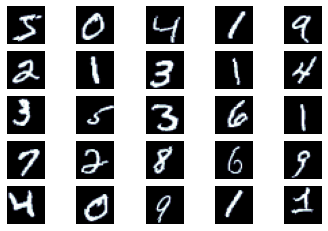

In [12]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)
#train 데이터 에 대한 부분 -> 랜덤하게 나열

### Split Dataset
The MNIST dataset comes with a training and test set, but not a validation set. We want to use a validation set to check how well our model performs on unseen data. Why don't we just use the test data? We should only be measuring our performance over the test set once, after all training is done. We can think of the validation set as a proxy test set we are allowed to look at as much as we want. 

Furthermore, we create a validation set, taking 10% of the training set. **Note:** the validation set should always be created from the training set. Never take the validation set from the test set. When researchers publish research papers they should be comparing performance across the test set and the only way to ensure this is a fair comparison is for all researchers to use the same test set. If the validation set is taken from the test set, then the test set is not the same as everyone else's and the results cannot be compared against each other.

First, we have to define the exact number of examples that we want to be in each split of the training/validation sets.


훈련/ 테스트 데이터 이미 따로 가져왔지만 split 또 하는 이유?
보통 test set 그리고 validation set 가져온다
validation set: 학습 할때 사용 -> 과적합 방지 unseen data 성능 떨어지지 않도록, 주기적으로 성능 확인 , 언제가 최고의 성능인지 훈련  과정 중에 알 수 있다.
                                hyper parameter 구할때도 사용, 

test set: 학습 끝났을 때 사용 , test set은 학습도중에 '전혀' 관련해서는 안된다.

In [13]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

Then, we use the `random_split` function to take a random 10% of the training set to use as a validation set. The remaining 90% will stay as the training set.

In [14]:
train_data, valid_data = data.random_split(train_data,
                                           
                                           [n_train_examples, n_valid_examples])
#torh에도 train test 나누는 기능이 있다. sklearn 과 유사하게

We can print out the number of examples again to check our splits are correct.

In [15]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


### Defining `DataLoader`
Next, we'll define a `DataLoader` for each of the training/validation/test sets. We can iterate over these, and they will yield batches of images and labels which we can use to train our model.

We only need to shuffle our training set as it will be used for stochastic gradient descent, and we want each batch to be different between epochs. As we aren't using the validation or test sets to update our model parameters, they do not need to be shuffled.

Ideally, we want to use the biggest batch size that we can. The 64 here is relatively small and can be increased if our hardware can handle it. **[pts. 5]**

In [16]:
#Batch : 5만 4천장을 한번에 하면 gpu가 터진다.
#그래서 사이즈를 나눈다. 한번에 64개씩, 128개씩 나눠서 가져온다. 
#데이터 분할 하는 부분

BATCH_SIZE = 64 #한번에 데이터를 64개씩 가져오겠다

train_iterator = data.DataLoader(train_data,  #training data order 
                                 shuffle=True,    #불러올때마다 랜덤하게 섞겠다,
                                 batch_size=BATCH_SIZE) #64개씩 불러 오겠다. 

valid_iterator = data.DataLoader(valid_data,  #test 할때는 shuffle 필요없으니 빼다,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [17]:
print(f'Length of train iterator: {len(train_iterator)}')
print(f'Length of validation iterator: {len(valid_iterator)}')
print(f'Length of test iterator: {len(test_iterator)}')

Length of train iterator: 844
Length of validation iterator: 94
Length of test iterator: 157


In [18]:
for X, y in train_iterator:  
  print(X.shape)  #데이터 받아오고
  print(y.shape)  #정답 받아오고

  break

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Modeling MLP

### Defining Model
Our model will be a neural network, specifically a multilayer perceptron (MLP) with two hidden layers. The image below shows the archicture of the model. 

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1)

Specifically, first we will flatten our 1x28x28 (1 color channel, 28 pixels height and width) image into a 784 element vector, also called 784 *features*. We flatten our input, as MLPs cannot handle two or three-dimensional data. Next, the 784 dimensional input is passed through the first hidden layer to transform it into 50 dimensions. Finally, an output layer which will transform it into a 10 dimensional vector. The output dimension should equal the number of classes within your data. Here we have ten digits, 0 - 9, so need our output to be 10 dimensions.


아직 cnn을 안배워서 1dimension인 784를 사용하겠다.
Linearlayer을 사용하면, input 다 더해 sum 해서 hidden으로

The transformation between 784 to 50, and 50 to 10 dimensions are done by `Linear` layers. These are also known as fully connected or affine layers. In these layers, every element in one layer is connected to every element in the next. We can think of these elements as *neurons*, as this architecture is inspired by how the human brain is made of millions of interconnected nodes, also called neurons. 

Each connection between a neuron in one layer and a neuron in the next has a *weight* associated with it. The input to one neuron is the sum of the weighted values of all neurons in the previous layer connected to it, plus a weighted bias term, where the bias value is always 1. The neuron then applies an *activation function* to this weighted sum. This activation function is a non-linear function that allows the neural network to learn non-linear functions between inputs and outputs. 

We define our MLP below, which consists of three linear layers. We first take the input batch of images and flatten them, so they can be passed into the linear layers. We then pass them through the first linear layer, `hidden_fc`, which calculates the weighted sum of the inputs, and then apply the *sigmoid* activation function elementwise. Finally, we pass this through the final linear layer, `output_fc`. We return not only the output but also the second hidden layer as we will do some analysis on it later.

Why did we choose hidden dimensions of 50 units? Why did we only have one hidden layers? There is no magic formula to tell us how many layers to use and how many neurons to have in each layer, and there is most probably a better set of values. However, the general idea is that neural networks extract features from data. Layers closer to the input learn to extract general features (e.g. lines, curves, edges), whilst later layers combine the features extracted from the previous layer into more high level features (e.g. the intersection of two lines making a cross, multiple curves make a circle). We force our neural network to learn these features by reducing the number of neurons in each layer. This way, it has to learn to compress information by extracting only the useful and general features. Thus, we want a neural network with multiple layers and some sort of information compression (reduced number of neurons in subsequent layers). **[pts. 10]**


#hidden layer을 하나만 쓰겠다!!

In [19]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.hidden_fc = nn.Linear(input_dim, 50) #입력 dimension 은 parameter 로 차원은 2차원에서 50차원으로
        self.output_fc = nn.Linear(50, output_dim) #50으로 출력되고= hidden layer, output_dim = 10
##layer 2개 정의하다.

    def forward(self, x):

        # x = [batch size, channel, height, width]
        batch_size = x.shape[0] #flatten으로 1자로 쭉 피다. 
        x = x.view(batch_size, -1)  # x라는 차원을 새로운 차원으로  batch size 는 그대로, 나머지 차원은 784로 ! = -1
        # x = [batch size, channel * height * width]

        s = self.hidden_fc(x)  # s는 hidden을 통해 sigmoid로 변환
        z = F.sigmoid(s)  #F: pytorch의 functional
        # z = [batch size, 100]

        y_pred = self.output_fc(z)  #최종적으로 prediction 되는 부분 
        #확률로 변환할려면 softmax 를 사용해야 하나, 여기서는 사용하지 않겠다.
        # y_pred = [batch size, output dim]

        return y_pred, z

We'll define our model by creating an instance of it and setting the correct input and output dimensions.

In [20]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10  #input , putput dimension은 입력으로 받아주다

model = MLP(INPUT_DIM, OUTPUT_DIM)

We can also create a small function to calculate the number of trainable parameters (weights and biases) in our model - in case all of our parameters are trainable.

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

The first layer has 784 neurons connected to 50 neurons, so 784*50 weighted connections plus 50 bias terms.

The second layer has 50 neurons connected to 10 neurons, 50*10 weighted connections plus 10 bias terms.

$$784 \cdot 50 + 50 + 50 \cdot 10 + 10 = 39,760 $$

In [22]:
print(f'The model has {count_parameters(model):,} trainable parameters')

#input 784  ->  hideen에 784가 50번 + bias 통해 +50 


The model has 39,760 trainable parameters


### Defining the Optimizer


어떻게 최적화를 시킬 것인가?
Next, we'll define our optimizer. This is the algorithm we will use to update the parameters of our model with respect to the loss calculated on the data.

We aren't going to go into too much detail on how neural networks are trained (see [this](http://neuralnetworksanddeeplearning.com/) article if you want to know how) but the gist is:
- pass a batch of data through your model
- calculate the loss of your batch by comparing your model's predictions against the actual labels
- calculate the gradient of each of your parameters with respect to the loss
- update each of your parameters by subtracting their gradient multiplied by a small *learning rate* parameter

We use the *SGD* algorithm with the default parameters to update our model. **[pts. 5]** Improved results could be obtained by searching over different optimizers and learning rates, however default Adam is usually a good starting off point. Check out [this](https://ruder.io/optimizing-gradient-descent/) article if you want to learn more about the different optimization algorithms commonly used for neural networks.

![optimizers](https://velog.velcdn.com/images%2Ffbdp1202%2Fpost%2F624e4a17-249f-4085-9c96-2378c608a970%2Fcs231n-07-902-Compare_Optimzations_02.gif)


자세한 내용은 대학원가서 배울 수 있다. 

In [23]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
#pytorch에서 많은 조건을 최적화 시킨 함수 optim 제공
#확률 경사 하강법을 하겠다 , learning rate: 0.1 
#grdient discent 를 사용하겠다. 

### Defining Criterion

에러가 얼마냐? 이걸 계산하겠다.

Then, we define a *criterion*, PyTorch's name for a loss/cost/error function. This function will take in your model's predictions with the actual labels and then compute the loss/cost/error of your model with its current parameters.

`CrossEntropyLoss` both computes the *softmax* activation function on the supplied predictions as well as the actual loss via *negative log likelihood*. 

Briefly, the softmax function is:

$$\text{softmax }(\mathbf{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$ 

This turns out 10 dimensional output, where each element is an unbounded real number, into a probability distribution over 10 elements. That is, all values are between 0 and 1, and together they all sum to 1. 

Why do we turn things into a probability distribution? So we can use negative log likelihood for our loss function, as it expects probabilities. PyTorch calculates negative log likelihood for a single example via:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, y) = -\log \big( \text{softmax}(\mathbf{\hat{y}})[y] \big)$$

$\mathbf{\hat{y}}$ is the $\mathbb{R}^{10}$ output, from our neural network, whereas $y$ is the label, an integer representing the class. The loss is the negative log of the class index of the softmax. For example:

$$\mathbf{\hat{y}} = [5,1,1,1,1,1,1,1,1,1]$$

$$\text{softmax }(\mathbf{\hat{y}}) = [0.8585, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157]$$

If the label was class zero, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 0) = - \log(0.8585) = 0.153 \dots$$

If the label was class five, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 5) = - \log(0.0157) = 4.154 \dots$$

So, intuitively, as your model's output corresponding to the correct class index increases, your loss decreases.

In [24]:
criterion = nn.CrossEntropyLoss()
#cross entropy를 사용하겠다.
#cross entropy에 softmax가 포함되어있다.

### Setting Device
We then define `device`. This is used to place your model and data on to a GPU, if you have one.

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#gpu를 다루는 cuda를 사용하겠다.
#False라 뜨면 CPU 사용, TRUE: GPU
#Colab에 해당하는 ㅂ분

We place our model and criterion on to the device by using the `.to` method.

In [26]:
model = model.to(device)
criterion = criterion.to(device)

Next, we'll define a function to calculate the accuracy of our model. This takes the index of the highest value for your prediction and compares it against the actual class label. We then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [27]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

#정확도 계산 하는 부분

### Training Code
We finally define our training loop.

This will:
- put our model into `train` mode
- iterate over our dataloader, returning batches of (image, label)
- place the batch on to our GPU, if we have one
- clear the gradients calculated from the last batch
- pass our batch of images, `x`, through to model to get predictions, `y_pred`
- calculate the loss between our predictions and the actual labels
- calculate the accuracy between our predictions and the actual labels
- calculate the gradients of each parameter
- update the parameters by taking an optimizer step
- update our metrics

Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode. The model we are using here does not use any of those layers, however it is good practice to get used to putting your model in training mode. **[pts. 10]**

In [28]:
#본격적으로training 짜는 코드

def train(model, iterator, optimizer, criterion, device):
#criterion : 평가
    epoch_loss = 0
    epoch_acc = 0

    # set as train mode
    model.train()  #지금 부터 model training 할거야! 선언하는 부분 
    #지금부터 weight 계산 할수 있어, 학습할꺼니깐 준비해

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        #64개씩 가져와 x, y에 분배 
        # assign data to device
        x = x.to(device)
        y = y.to(device)
        #x, y -> gpu로 전달

        # clear the previous gradient
        optimizer.zero_grad()  #: for loop으로 전에 남아있는 gredient를 지워주어라

        # feed forward 
        y_pred, _ = model(x)  #x가 모델에 들어가서 출력을 받아올 수 있다. 

        # compute loss (error)  #error 계산 
        loss = criterion(y_pred, y)  #입력으로 모델의 output 과 실제 정답값 

        # compute accuracy
        y_prob = F.softmax(y_pred, dim=-1)   #확률을 받아오다
        acc = calculate_accuracy(y_prob, y) #실제확률하고 출력값 비교후 정확도 확인

        # back propagation
        loss.backward()  #loss 를 계산 했으니, loss를 back prop 해라! 한 줄이면 back prop 해결 가능한 부분

        # gradient decent
        optimizer.step()  # back prop 계산 한 걸 opmizer에 넣어 반영해주다

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)  #한번 쭉 돌았을때 반복도, loss 등등 얼마인지 확인 가능 




### Evaluation Code


validationset , test set 평가를 위한 부분

The evaluation loop is similar to the training loop. The differences are:
- we put our model into evaluation mode with `model.eval()`
- we wrap the iterations inside a `with torch.no_grad()`
- we do not zero gradients as we are not calculating any
- we do not calculate gradients as we are not updating parameters
- we do not take an optimizer step as we are not calculating gradients

`torch.no_grad()` ensures that gradients are not calculated for whatever is inside the `with` block. As our model will not have to calculate gradients, it will be faster and use less memory. 

In [29]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    # set as evaluation mode
    model.eval()
    #어떤 짓을 하던 모델은 바뀌지 않아, 평가만 할거야: model.eval() 
    #feed forward 등등 해도 모델은 바뀌지 않다.
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The final step before training is to define a small function to tell us how long an epoch took.

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#시간 부분인데, 관심있는 분은 보라

### Let's train!

We're finally ready to train!

During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`). **[pts. 5]**

In [31]:
EPOCHS = 10

best_valid_loss = float('inf')  #loss가 낮아질때 마다 갱신해주다
#train 1번 : epoch 1번

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer,
                                  criterion, device)  #train 함수는 위에서 짠 함수 부분이다.
    
    # evulate the model with validation set
    valid_loss, valid_acc = evaluate(model, valid_iterator,
                                  criterion, device)  #평가용 부분 # 학습시킬 꺼 아니니깐 , optimizer는 필요없다

# 방금 계산 한 loss가 기존 loss 보다 낮으면 갱신 최솟값을 구하는 부분
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # save the model
        torch.save(model.state_dict(), 'tut1-model.pt')  # torch에서 save기능 -> 모델 , dictionary 형태로 저장

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

c:\Users\kimjunseok\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 1.046 | Train Acc: 69.36%
	 Val. Loss: 0.727 |  Val. Acc: 78.78%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 0.602 | Train Acc: 82.71%
	 Val. Loss: 0.535 |  Val. Acc: 84.38%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.457 | Train Acc: 87.26%
	 Val. Loss: 0.410 |  Val. Acc: 88.48%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 29s
	Train Loss: 0.377 | Train Acc: 89.64%
	 Val. Loss: 0.355 |  Val. Acc: 90.35%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.328 | Train Acc: 91.02%
	 Val. Loss: 0.313 |  Val. Acc: 91.19%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 32s
	Train Loss: 0.298 | Train Acc: 91.74%
	 Val. Loss: 0.288 |  Val. Acc: 92.35%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 0.274 | Train Acc: 92.43%
	 Val. Loss: 0.269 |  Val. Acc: 92.85%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 27s
	Train Loss: 0.256 | Train Acc: 92.85%
	 Val. Loss: 0.246 |  Val. Acc: 92.94%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 32s
	Train Loss: 0.244 | Train Acc: 93.17%
	 Val. Loss: 0.234 |  Val. Acc: 93.09%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 30s
	Train Loss: 0.230 | Train Acc: 93.52%
	 Val. Loss: 0.228 |  Val. Acc: 93.56%


Afterwards, we load our the parameters of the model that achieved the best validation loss and then use this to evaluate our model on the test set.

In [32]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

#test set에서 받아와서 계산

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Our model achieves 95.8% accuracy on the test set.

This can be improved by tweaking hyperparameters, e.g. number of layers, number of neurons per layer, optimization algorithm used, learning rate, etc. 

In [33]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%') 

Test Loss: 0.143 | Test Acc: 95.92%


## Examining the Model

Now we've trained our model, there are a few things we can look at. Most of these are simple exploratory analysis, but they can offer some insights into your model.

An important thing to do is check what examples your model gets wrong and ensure that they're reasonable mistakes.

The function below will return the model's predictions over a given dataset. It will return the inputs (image) the outputs (model predictions) and the ground truth labels. **[pts. 5]**

In [34]:
def get_predictions(model, iterator, device):
    #예측하는 영역
    #loss 는 계산 안하되, 중간값을 받아오는 부분
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

We can then get these predictions and, by taking the index of the highest predicted probability, get the predicted labels.

In [35]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)

### Confusion Matrix

Then, we can make a confusion matrix from our actual labels and our predicted labels.

In [36]:
#정답값, 예측값 알 수 있는 matrix
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

The results seem reasonable enough, the most confused predictions-actuals are: 3-5 and 2-7.

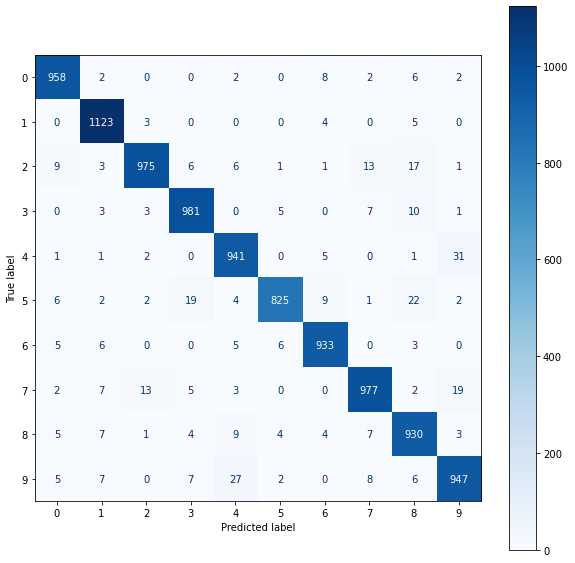

In [37]:
plot_confusion_matrix(labels, pred_labels)

#5번 같은 경우 많이 틀렸다. 


### Which one is incorrect?
Next, for each of our examples, we can check if our predicted label matches our actual label.

In [38]:
corrects = torch.eq(labels, pred_labels)
print(corrects)


tensor([True, True, True,  ..., True, True, True])


We can then loop through all of the examples over our model's predictions and store all the examples the model got incorrect into an array.

Then, we sort these incorrect examples by how confident they were, with the most confident being first.

In [39]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

#몇개나 맞췄는지, 틀린 부분을 가져오는 부분
#관심있는 학생은 코드를 뜯어보고, 중요하는 부분은 아니다

We can then plot the incorrectly predicted images along with how confident they were on the actual label and how confident they were at the incorrect label.

In [40]:
def plot_most_incorrect(incorrect, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]

        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), \
                  cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
        #gpu에서 cpu로 바꿔야 , 그림을 그릴 수 있다.
    fig.subplots_adjust(hspace=0.5)

Below we can see the 25 images the model got incorrect and was most confident about.

A lot of these digits are irregular, so it's difficult for the model to do well on these. The images that do look fine, if you squint you can sort of see why the model got it wrong.

Why is the neural network so confident on the irregular digits? Surely if it's a weird looking digit then the output of the softmax should be close to evenly distributed across a few digits the model isn't sure about, right? Well, no. The model has been trained to only be incredibly confident about its predictions, and thus when it sees an image it will always be confident about what it is.

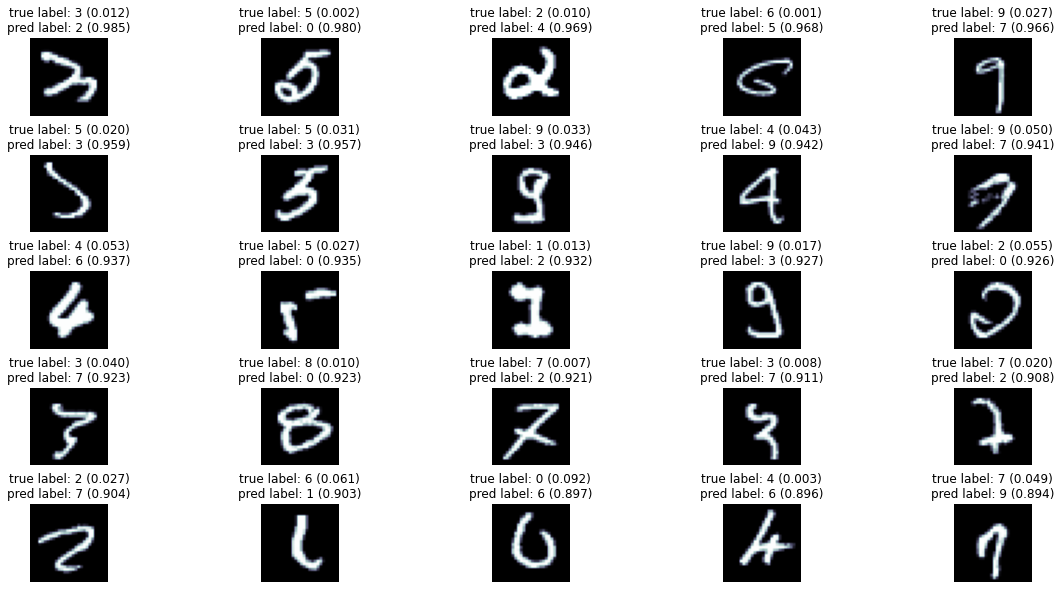

In [41]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)
#맨 처음 정답이 3인데, 2로 예측 
#틀렸지만 , reasonable 한 이유로 틀렸네 알 수 있다.

### Scattering the data and it's representation

Another thing we can do is get the intermediate representations from the model and try to visualize them.

The function below loops through the provided dataset and gets the intermediate representation from the layer before that, the second hidden layer.


입력데이터에 중요한 부분을 추출   -> 각 class 별로 잘 찢어지도록 학습이 되다. 
input 정보로 그림을 그려보고, output 정보를 보고 그려보고
둘이 비슷하면 학습이 잘되었다라고 볼 수 있다.

In [42]:
def get_representations(model, iterator, device):

    model.eval()

    inputs = []    
    outputs = []    
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):          
            inputs.append(x)
            
            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())            
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    inputs = torch.cat(inputs, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, inputs, labels

We run the function to get the representations.

In [43]:
outputs, inputs, labels = get_representations(model,
                                                   test_iterator,
                                                   device)

  0%|          | 0/157 [00:00<?, ?it/s]

c:\Users\kimjunseok\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


The data we want to visualize is in ten dimensions and 100 dimensions. We want to get this down to two dimensions, so we can actually plot it. 

The first technique we'll use is PCA (principal component analysis). First, we'll define a function to calculate the PCA of our data, and then we'll define a function to plot it.

In [44]:
#PCA라는 분석 
#차원이 넓은 것을 줄여주는 방법
#주성분 분석 2 dimension하는 부분 
#sklearn 에서 제공 
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [45]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

First, we plot the data into 2D space using reduction with PCA.

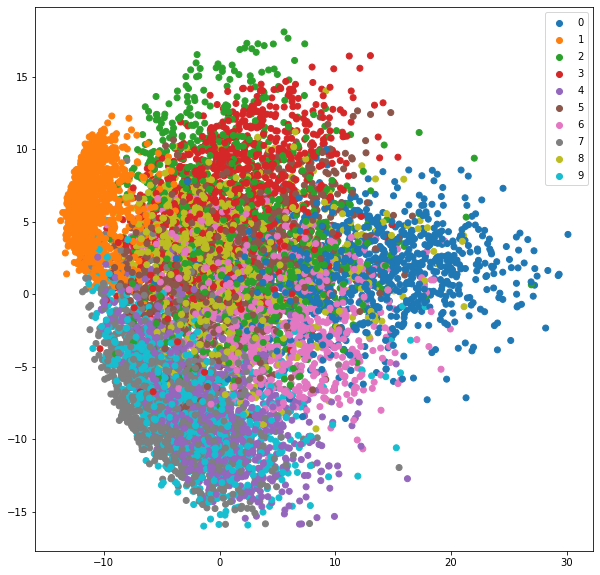

In [46]:
output_pca_data = get_pca(inputs.reshape(inputs.shape[0], -1))
plot_representations(output_pca_data, labels)

#784차원에 대해 그려주다
#1만 잘 분류되고, 나머지는 엉망진창이다.

Second, we plot the representations from the ten dimensional output layer, reduced down to two dimensions.

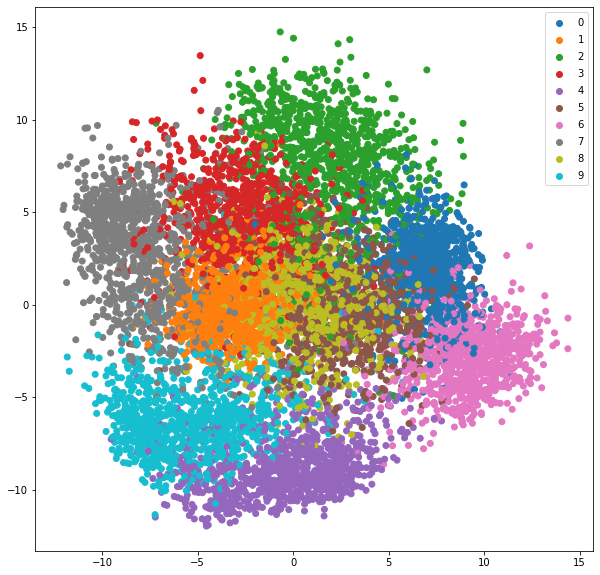

In [47]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)
#output 결과를 pCA 시킨 결과 
#다차원의 결과가 이렇게 바뀌었다

#아까 전보다 linearly separable 해졌다.
#훨씬 더 잘 분류된 상황

#입력 형태보다는 ouput 형태에서 잘 분류된 상황

### Weight Visualization

E, L , F 학습할 떄 특징 추출 한 부분 

Finally, we can plot the weights in the first layer of our model. 

The hope is that there's maybe one neuron in this first layer that's learned to look for certain patterns in the input and thus has high weight values indicating this pattern. If we then plot these weights, we should see these patterns.

In [48]:
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

Looking at these weights we see a few of them look like random noise but some of them do have weird patterns within them. These patterns show "ghostly" image looking shapes, but are clearly not images.

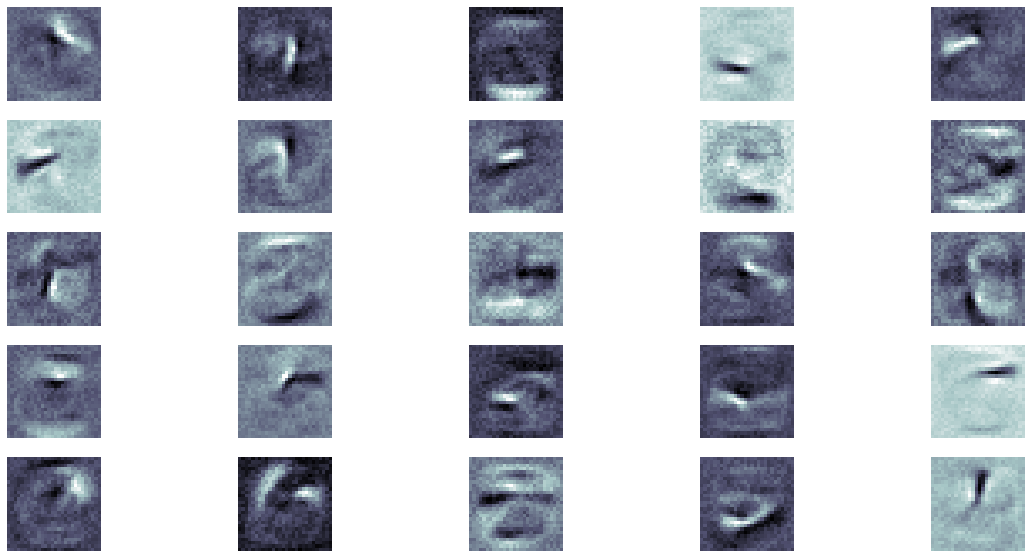

In [49]:
N_WEIGHTS = 25

weights = model.hidden_fc.weight.data

plot_weights(weights, N_WEIGHTS)

#특징들의 activation 되는 부분 
#이런 걸로 decition이 되는 구나

## TODO!

Make your model more smarter! You can achieve > 97.5% accuracy. **[pts. 50]**

Suggestions:
- more deeper! (may be more layers?)
- other optimizer (*e.g.*, Adam, Adadelta, e.t.c.)
- other activation fuction (*e.g.*, Relu)

In [58]:
# Build model
#layer을 더 쌀아보고
#sigmoid 말고 lelu
#optimazer을 바꾸거나 Adam 등등
#criterion을 사용해야 한다
#나만의 

class MLP2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        ##### Build your own layers #####

        self.hidden_fc1 = nn.Linear(input_dim, 75)

        self.hidden_fc2 = nn.Linear(75, 50)

        self.hidden_fc3 = nn.Linear(50, 25)
        self.output_fc = nn.Linear(25, output_dim)

    def forward(self, x):
        ##### Build your own feed forward #####
        batch_size = x.shape[0] 
        x = x.view(batch_size, -1)
        s1 = self.hidden_fc1(x)
        z1 = F.relu(s1)

        s2 = self.hidden_fc2(z1)
        z2 = F.relu(s2)

        s3 = self.hidden_fc3(z2)
        z3 = F.relu(s3)

        y_pred = self.output_fc(z3)

        return y_pred, z3

In [59]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP2(INPUT_DIM, OUTPUT_DIM).to(device)

In [60]:
# Optimizer
optimizer = optim.Adam(model.parameters())

In [56]:
EPOCHS = 15

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # evulate the model with validation set
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # save the model
        torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 0.643 | Train Acc: 79.69%
	 Val. Loss: 0.327 |  Val. Acc: 90.34%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.268 | Train Acc: 92.00%
	 Val. Loss: 0.264 |  Val. Acc: 92.12%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 28s
	Train Loss: 0.207 | Train Acc: 93.60%
	 Val. Loss: 0.179 |  Val. Acc: 94.19%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.180 | Train Acc: 94.46%
	 Val. Loss: 0.181 |  Val. Acc: 94.60%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 38s
	Train Loss: 0.164 | Train Acc: 94.90%
	 Val. Loss: 0.149 |  Val. Acc: 95.18%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 31s
	Train Loss: 0.150 | Train Acc: 95.48%
	 Val. Loss: 0.150 |  Val. Acc: 95.33%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 29s
	Train Loss: 0.142 | Train Acc: 95.59%
	 Val. Loss: 0.144 |  Val. Acc: 95.72%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 37s
	Train Loss: 0.128 | Train Acc: 96.05%
	 Val. Loss: 0.137 |  Val. Acc: 95.66%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 35s
	Train Loss: 0.126 | Train Acc: 96.13%
	 Val. Loss: 0.139 |  Val. Acc: 95.86%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 33s
	Train Loss: 0.120 | Train Acc: 96.26%
	 Val. Loss: 0.128 |  Val. Acc: 96.02%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 41s
	Train Loss: 0.118 | Train Acc: 96.37%
	 Val. Loss: 0.125 |  Val. Acc: 95.97%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 33s
	Train Loss: 0.113 | Train Acc: 96.58%
	 Val. Loss: 0.133 |  Val. Acc: 96.11%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 32s
	Train Loss: 0.110 | Train Acc: 96.61%
	 Val. Loss: 0.126 |  Val. Acc: 95.99%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 37s
	Train Loss: 0.107 | Train Acc: 96.62%
	 Val. Loss: 0.118 |  Val. Acc: 96.43%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 32s
	Train Loss: 0.102 | Train Acc: 96.81%
	 Val. Loss: 0.117 |  Val. Acc: 96.24%


In [63]:
# evaluate with test data
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

In [64]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.078 | Test Acc: 97.53%
